In [5]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


Change the project structure from rainy/cloudy etc to train/test/val

In [8]:
!pip install split-folders

import splitfolders

# 1. Define where your original data is
input_folder = "/content/drive/MyDrive/Colab Notebooks/Weather Project/Multi-class Weather Dataset"

# 2. Define where you want the new split data to go
output_folder = "/content/drive/MyDrive/Colab Notebooks/Weather Project/Dataset"

# 3. Run the split
# ratio=(train, val, test) -> (80%, 10%, 10%)
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .1, .1), group_prefix=None)

print("Success! Your data is now split into train, val, and test.")

Copying files: 3 files [08:24, 168.30s/ files]
Copying files: 1125 files [08:52,  2.11 files/s]

Success! Your data is now split into train, val, and test.


Setting up folder

In [6]:
# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '/content/drive/MyDrive/Colab Notebooks/Weather Project/Dataset'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
path = '/content/drive/MyDrive/Colab Notebooks/Weather Project/'
fullpath = f'{path}'


Load the dataset

In [7]:
%cd {fullpath}

/content/drive/MyDrive/Colab Notebooks/Weather Project


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Point to the NEW folders
train_dir = './Dataset/train'
val_dir =   './Dataset/val'
test_dir =  './Dataset/test'


Classes found: ['Cloudy', 'Rain', 'Shine', 'Sunrise']


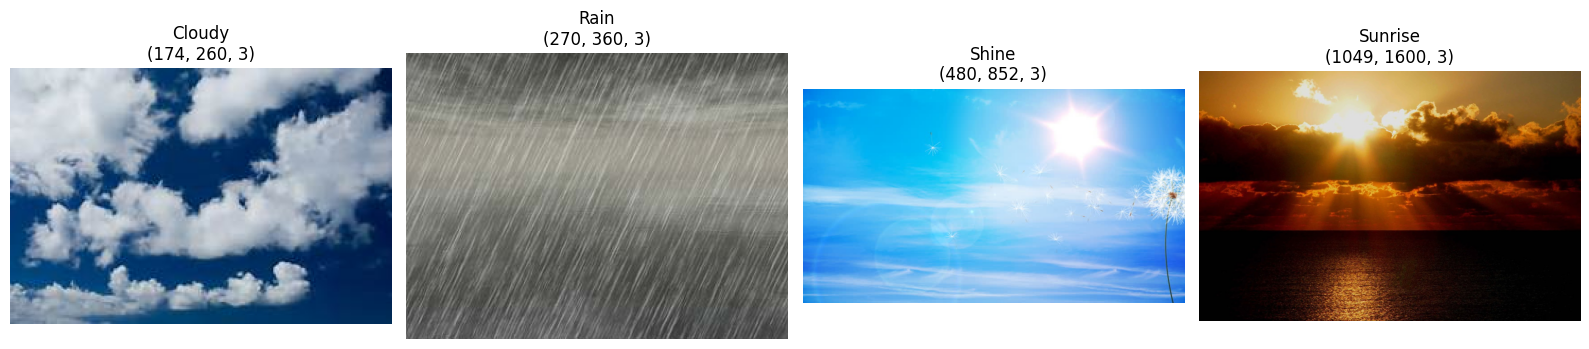

In [9]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# --- Exploratory Data Analysis (EDA) ---
# This block checks your folders and displays one random image from each class

# 1. Identify the class names from the training folder automatically
try:
    class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    print(f"Classes found: {class_names}")

    # 2. Setup the plot
    plt.figure(figsize=(16, 5))

    # 3. Loop through classes and plot a random image from each
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)

        # Filter for image files only (jpg, png, webp)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]

        if images:
            # Pick a random image
            random_image = random.choice(images)
            img_path = os.path.join(class_path, random_image)

            # Load and display
            img = mpimg.imread(img_path)
            plt.subplot(1, len(class_names), i + 1)
            plt.imshow(img)
            plt.title(f"{class_name}\n{img.shape}") # Shows class name and image size (Height, Width, Channels)
            plt.axis('off')
        else:
            print(f"No images found in folder: {class_name}")

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not run EDA. Make sure 'train_dir' is defined and points to the correct path.\nError: {e}")

Building the Model (Transfer Learning)
We will use Xception as the "base" and add custom layers on top.

In [10]:
# 1. Setup the Data Generators
# We apply "Augmentation" to training data to prevent overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values
    rotation_range=30,     # Rotate images randomly
    zoom_range=0.2,        # Zoom in/out
    horizontal_flip=True,  # Flip left/right
    fill_mode='nearest'
)

# Validation and Test data should NOT be augmented, only rescaled
val_test_datagen = ImageDataGenerator(rescale=1./255)

# 2. Load the images from the folders
print("Loading Training Data:")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299), # Xception expects 299x299
    batch_size=32,
    class_mode='categorical'
)

print("Loading Validation Data:")
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

print("Loading Test Data:")
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False # Important for evaluation!
)

Loading Training Data:
Found 899 images belonging to 4 classes.
Loading Validation Data:
Found 111 images belonging to 4 classes.
Loading Test Data:
Found 115 images belonging to 4 classes.


**Model Summmary**

In [11]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf # Import tensorflow for optimizers

# 1. Load the pre-trained base model
base_model = Xception(
    weights='imagenet',       # Use patterns learned from 14M images
    include_top=False,        # Drop the top (classification) layer
    input_shape=(299, 299, 3)
)

# 2. Freeze the base model (so we don't destroy pre-trained weights)
base_model.trainable = False

# 3. Add your custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) # Inner dense layer
x = Dropout(0.5)(x)                  # Regularization (drop 50% of neurons)
output = Dense(4, activation='softmax')(x) # 4 output classes (Cloudy, Rain, Shine, Sunrise)

# 4. Combine them
model = Model(inputs=base_model.input, outputs=output)

# 5. Compile
learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 21,387,052 (81.59 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

**Train the Model**
 We will use a "Checkpoint" to save the best version of the model automatically.

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Save the best model only (if validation accuracy improves)
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/Weather Project/best_weather_model.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

# Train for 10 epochs (passes through the dataset)
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 293s 9s/step - accuracy: 0.6144 - loss: 0.9293 - val_accuracy: 0.8829 - val_loss: 0.3446
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8765 - loss: 0.3381 - val_accuracy: 0.9099 - val_loss: 0.2701
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8857 - loss: 0.2904 - val_accuracy: 0.8829 - val_loss: 0.2677
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9124 - loss: 0.2382 - val_accuracy: 0.9459 - val_loss: 0.2310
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9056 - loss: 0.2159 - val_accuracy: 0.9189 - val_loss: 0.2192
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9288 - loss: 0.1663 - val_accuracy: 0.9459 - val_loss: 0.2394
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9384 - loss: 0.1745 - val_accuracy: 0.9099 - val_loss: 0.2298
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9415 - loss: 0.1592 - val_accuracy: 0.9459 - val_loss

**Visualize Results**
To see a graph of how your model improved over time.

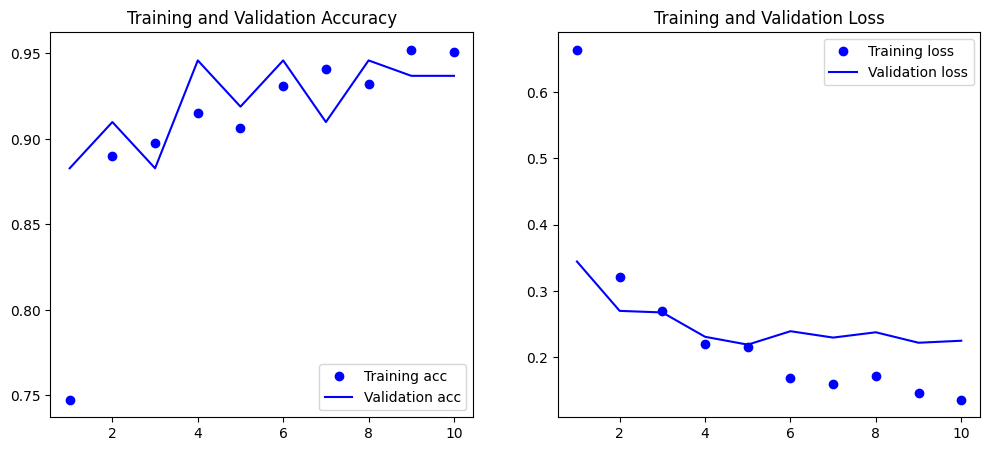

In [13]:
import matplotlib.pyplot as plt

# Extract results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

**Testing** on images the model has never seen before

In [14]:
print("Evaluating on Test Set...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Evaluating on Test Set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 15s/step - accuracy: 0.9204 - loss: 0.2881
Test Accuracy: 93.91%


**TESTING ON RANDOM IMAGE FROM THE INTERNET**

In [15]:
from tensorflow.keras.preprocessing.image import load_img

In [16]:
X = load_img("./Dataset/rainy-weather-and-raindrops-on-the-glass.webp")

In [17]:
import numpy as np

In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model # Import load_model

# Path to an image you want to test (upload one to Colab files first)
img_path = "./Dataset/rainy-weather-and-raindrops-on-the-glass.webp"

# Load the best trained model (ensure this path matches where ModelCheckpoint saved it)
model_path = 'best_weather_model.keras'
model = load_model(model_path)

img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

predictions = model.predict(x)
class_labels = list(train_generator.class_indices.keys())
print(f"Predicted Class: {class_labels[np.argmax(predictions)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
Predicted Class: Rain


**CONVERT THE MODEL TO A LIGHTER VERSION IE TENSORFLOW LITE THAT CAN EASILY BELOADED TO AWS LAMBDA.**

In [ ]:
import tensorflow as tf

# 1. Load your trained model
model = tf.keras.models.load_model('best_weather_model.keras')

# 2. Initialize the Converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# 3. Convert the model
tflite_model = converter.convert()

# 4. Save the TFLite file
with open('weather_model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

print("Success! Download 'weather_model.tflite' from the files tab.")

Saved artifact at '/tmp/tmp2fzxn2oz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133784211739408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133784191999376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133784191999568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133784192000528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133784191998608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133784192001680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133784191999184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133784191998992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133784191999760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133784191995536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1337841919978